# ArcGIS Portal Login Tracker Graph Builder
This script uses data outputted from the ArcGIS Portal Login Tracker to build standard basic graphs of user login data. The graphs built here assume the original tracker script grabs logs user roles; certain graphs cannot be generated without this data.

Graphs are built entirely seperately, allowing admin users to build on those they choose, rather than the entire set. Each graph utilizes the initialization code, which must be run first.

## Paramaters
`csv_file`: Path to your login tracker data CSV.

`figure_directory`: Path to the directory graphs will be saved to. This must end in a slash character.

`show_plots`: Whether or not to show plots within the notebook. Setting this to `False` will not show plots, but will save them to the figure directory.

`plot_role_rename`: A dictionary of old and new role names. Names included here will be changed before building the graph resulting in updated column names, graph key values, etc. This variable can be ignored if roles are not included in the CSV file.

`single_plot_color`: The color used when building most graph elements (lines for time series and bar chart bars). A color name or hex code can be used.

`multi_plot_colors`: A list of the colors used when building graph elements that require multiple colors (only applies to graphs utilizing user role data). Color names or hex codes can be used. This variable can be ignored if roles are not included in the CSV file.

## Initialization

In [39]:
#Parameters
csv_file = 'C:/path/to/your/file.csv'
figure_directory = 'C:/path/to/figures/'
show_plots = True

plot_role_rename = {'org_admin':'Admin'}
single_plot_color = '#365c8d'
multi_plot_colors = ['#9fda3a','#4ac16d','#1fa187','#277f8e','#365c8d','#46337e','#440154'] 
##Number of Colors must be Equal to or Greater than the Number of User Roles for the Organization

In [40]:
#Import Libraries
from datetime import datetime
import csv
import matplotlib.pyplot as plt

## Load and Format Data

In [41]:
#Read CSV Data
with open(csv_file) as file:
    login_data = [row for row in csv.DictReader(file)]

for record in login_data:
    record['lastLogin'] = datetime.strptime(record['lastLogin'], '%Y-%m-%d')

In [42]:
#Parameter Validation
if not isinstance(show_plots, bool):
    raise TypeError('show_plots must be a boolean value.')
if figure_directory[-1] not in  ['/','\\']:
    raise ValueError('Figure directory must end in a slash character.')
if not isinstance(multi_plot_colors, list):
    raise TypeError('Plot colors must be a list.')
if not isinstance(plot_role_rename, dict):
    raise TypeError('Plot renaming values must be a dictionary.')

##Update Role Names
if 'role' in login_data[0]:
    if plot_role_rename != {}:
        role_error = [role for role in plot_role_rename if role not in {r['role'] for r in login_data}]
        if len(role_error) > 0:
            raise ValueError(f'The following role values in plot_role_rename are not present in the dataset: {', '.join(role_error)}.')
        
        for record in login_data:
            if record['role'] in plot_role_rename:
                record['role'] = plot_role_rename[record['role']]

In [43]:
#Get a List of unique Dates in Order
unique_dates = []
for record in login_data:
    if record['lastLogin'] not in unique_dates:
        unique_dates.append(record['lastLogin'])

unique_dates_str = [str(date).split(' ')[0] for date in unique_dates]

#Get User Counts for Each Date
date_counts = {date: 0 for date in unique_dates}
for record in login_data:
    date_counts[record['lastLogin']] += 1

date_counts_str = {}
for date in date_counts:
    date_counts_str[str(date).split(' ')[0]] = date_counts[date]

## Login Count - Last 7 Day Totals

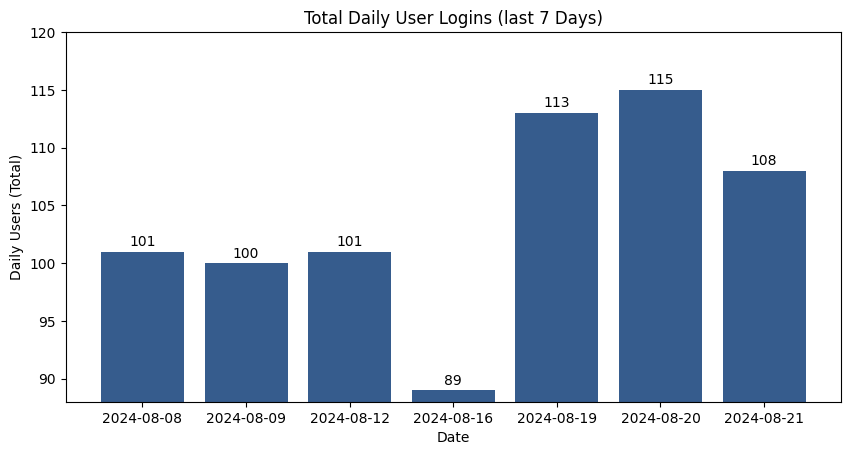

In [44]:
#Get the Last Seven Days
if len(unique_dates_str) >= 7:
    recent_dates = unique_dates_str[-7:]
else:
    recent_dates = unique_dates_str

recent_date_counts = {key:date_counts_str[key] for key in date_counts_str.keys() if key in recent_dates}

#Build Bar Chart
fig, ax = plt.subplots()
ax.bar(list(recent_date_counts.keys()), list(recent_date_counts.values()), color = single_plot_color)
ax.set_ylim([min(list(recent_date_counts.values())) - 1, max(list(recent_date_counts.values())) + 5])
ax.bar_label(ax.containers[0], label_type = 'edge', padding = 2)
plt.title(f'Total Daily User Logins (last {len(recent_date_counts)} Days)')
ax.set_ylabel('Daily Users (Total)')
ax.set_xlabel('Date')
fig.set_figwidth(10)

#Save/Show Plot
plt.savefig(figure_directory + 'daily_user_logins_date.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()

## Time Series - All Time Totals by Day

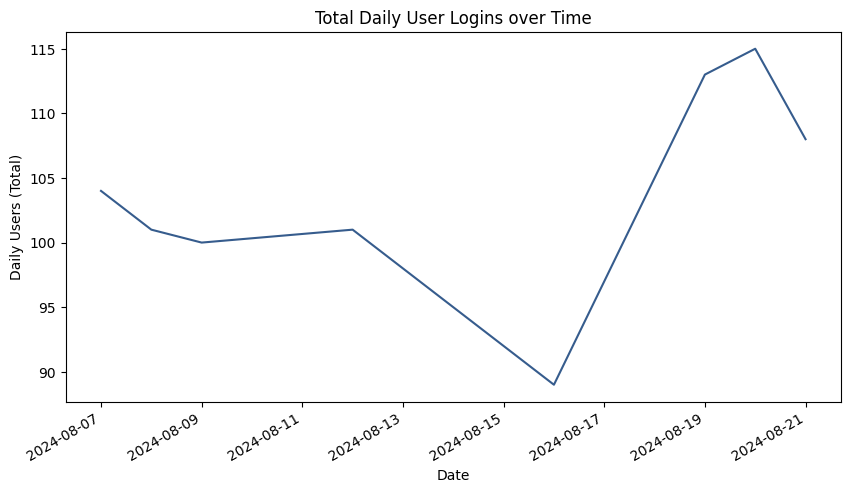

In [45]:
#Build Time Series
fig, ax = plt.subplots()
plt.plot(date_counts.keys(),date_counts.values(), single_plot_color)
plt.title('Total Daily User Logins over Time')
ax.set_ylabel('Daily Users (Total)')
ax.set_xlabel('Date')
fig.set_figwidth(10)
plt.xticks(rotation=30, ha='right')

#Save/Show Plot
plt.savefig(figure_directory + 'daily_user_logins_timeSeries.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()

## Bar Chart - Average Totals by Day of Week

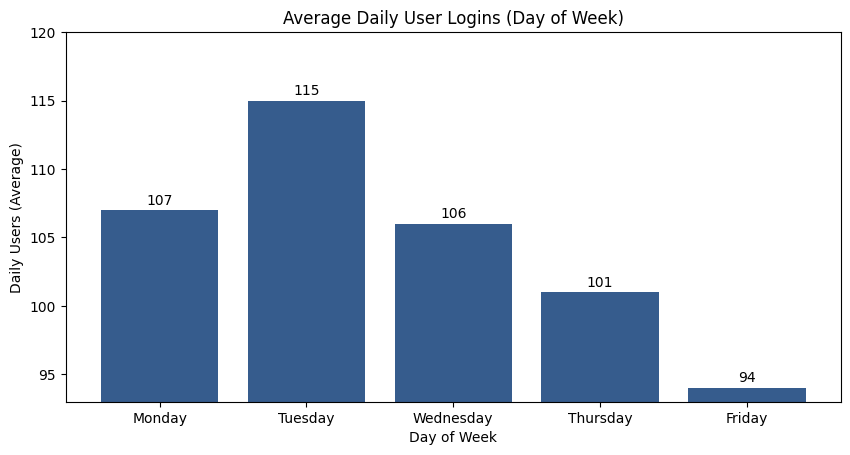

In [46]:
#Bar Chart (By Day of Week)
day_values = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
    4:'Friday' ,5:'Saturday', 6:'Sunday'}
day_counts = {'Monday':0,'Tuesday':0, 'Wednesday':0, 'Thursday':0,
    'Friday':0, 'Saturday':0, 'Sunday':0}
per_day_of_week = {'Monday':0,'Tuesday':0, 'Wednesday':0, 'Thursday':0,
    'Friday':0, 'Saturday':0, 'Sunday':0}
all_dates = []

for record in login_data:
    day_val = day_values[record['lastLogin'].weekday()]
    if record['lastLogin'] not in all_dates:
        all_dates.append(record['lastLogin'])
        per_day_of_week[day_val] += 1
    day_counts[day_val] += 1

#Normalize Counts
day_counts = {day:int(day_counts[day]/per_day_of_week[day]) for day in day_counts.keys() if day_counts[day] != 0}

#Build Bar Chart
fig, ax = plt.subplots()
ax.bar(list(day_counts.keys()), list(day_counts.values()), color = single_plot_color)
ax.set_ylim([min(day_counts.values()) - 1, max(day_counts.values()) + 5])
ax.bar_label(ax.containers[0], label_type = 'edge', padding = 2)
plt.title('Average Daily User Logins (Day of Week)')
ax.set_ylabel('Daily Users (Average)')
ax.set_xlabel('Day of Week')
fig.set_figwidth(10)

#Save/Show Plot
plt.savefig(figure_directory + 'daily_user_logins_DOW.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()

## Total Logins by User Type

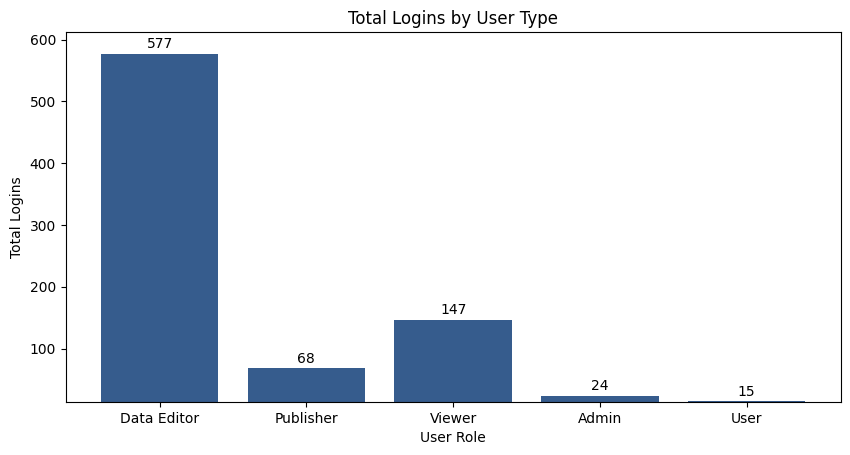

In [47]:
#Get Counts for User Type
user_role_counts = {record['role']:0 for record in login_data}
for record in login_data:
    user_role_counts[record['role']] += 1

#Build Bar Chart
fig, ax = plt.subplots()
ax.bar(list(user_role_counts.keys()), list(user_role_counts.values()), color = single_plot_color)
ax.set_ylim([min(user_role_counts.values()) - 1, max(user_role_counts.values()) + 35])
ax.bar_label(ax.containers[0], label_type = 'edge', padding = 2)
plt.title('Total Logins by User Type')
ax.set_ylabel('Total Logins')
ax.set_xlabel('User Role')
fig.set_figwidth(10)

#Save/Show Plot
plt.savefig(figure_directory + 'logins_by_userrole.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()

## Logins by User Type - Last 7 Day Totals

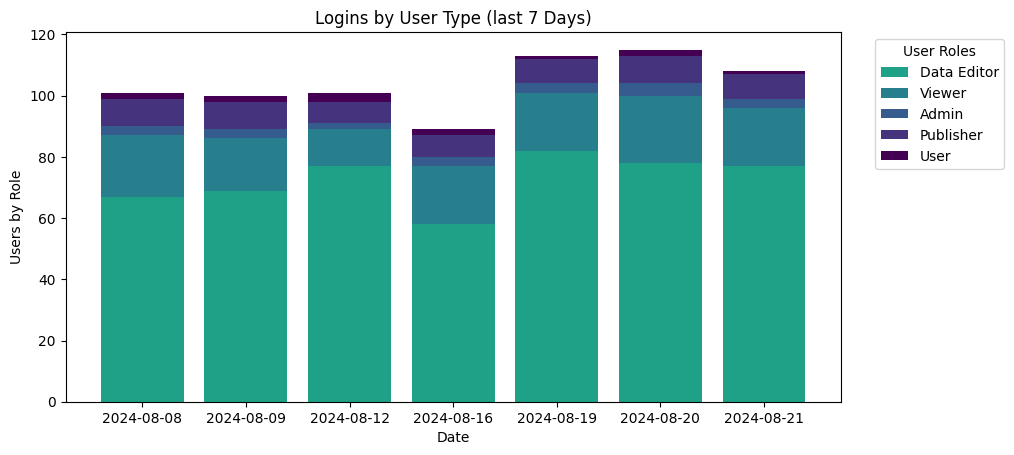

In [48]:
#Get the Last Seven Days
if len(unique_dates) >= 7:
    recent_dates = unique_dates[-7:]
else:
    recent_dates = unique_dates

#Get a List of User Roles
user_roles = {record['role'] for record in login_data}

#Create a Nested Dictionary with Roles and Dates
user_role_day_counts = {role:{date:0 for date in recent_dates} for role in user_roles}

#Get Counts
for record in login_data:
    try:
        user_role_day_counts[record['role']][record['lastLogin']] += 1
    except:
        pass

#Change From Dates to String to Help with Formatting
user_role_day_counts = {role:{str(date).split(' ')[0]:user_role_day_counts[role][date] for date in user_role_day_counts[role]} for role in user_role_day_counts}

#Build Bar Chart
fig, ax = plt.subplots()
bottom = [0 for date in recent_dates]
colors = multi_plot_colors[-len(user_roles):]
for index, role in enumerate(user_role_day_counts):
    plt.bar(list(user_role_day_counts[role].keys()), list(user_role_day_counts[role].values()), bottom = bottom, color = colors[index])
    bottom = [x + y for x, y in zip(bottom, list(user_role_day_counts[role].values()))]

plt.title(f'Logins by User Type (last {len(recent_dates)} Days)')
ax.set_ylabel('Users by Role')
ax.set_xlabel('Date')
plt.legend(list(user_roles), title = 'User Roles', loc = 'upper right', bbox_to_anchor = (1.22, 1.00))
fig.set_figwidth(10)

#Save/Show Plot
plt.savefig(figure_directory + 'logins_by_userrole_date.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()

## Time Series - All Time Totals by User Role

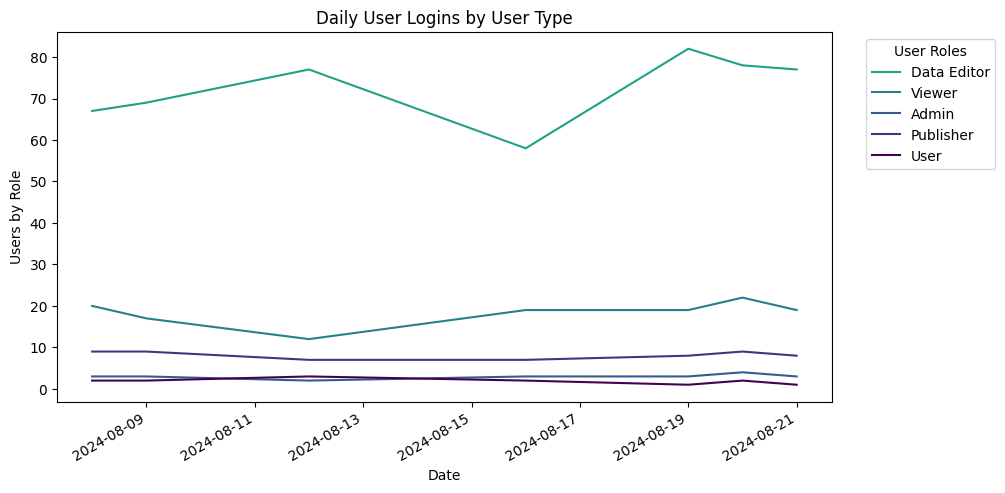

In [50]:
#Get the Last Seven Days
if len(unique_dates) >= 7:
    recent_dates = unique_dates[-7:]
else:
    recent_dates = unique_dates

#Get a List of User Roles
user_roles = {record['role'] for record in login_data}

#Create a Nested Dictionary with Roles and Dates
user_role_day_counts = {role:{date:0 for date in recent_dates} for role in user_roles}

#Get Counts
for record in login_data:
    try:
        user_role_day_counts[record['role']][record['lastLogin']] += 1
    except:
        pass

#Build Plot
#Build Time Series
fig, ax = plt.subplots()
colors = multi_plot_colors[-len(user_roles):]
for index, role in enumerate(user_role_day_counts):
    plt.plot(list(user_role_day_counts[role].keys()), list(user_role_day_counts[role].values()), colors[index])

plt.title('Daily User Logins by User Type')
ax.set_ylabel('Users by Role')
ax.set_xlabel('Date')
fig.set_figwidth(10)
plt.xticks(rotation=30, ha='right')
plt.legend(list(user_roles), title = 'User Roles', loc = 'upper right', bbox_to_anchor = (1.22, 1.00))
#Save/Show Plot
plt.savefig(figure_directory + 'logins_by_userrole_timeSeries.png', bbox_inches = 'tight')
if show_plots is True:
    plt.show()
else:
    plt.close()